In [ ]:
import autoencoder
import my_scripts
import utils
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import linregress
from statsmodels.stats.weightstats import ztest as ztest
import tqdm
import GM
from scipy.stats import pearsonr
import time
from sklearn.preprocessing import OneHotEncoder
import pickle

In [3]:
# Load the autoencoder and one hot encoder

SEED = 11
MSA_length = 202
AA_latent = 50
latent_dim = 100

AE_v1 = autoencoder.Autoencoder_v1(taille=MSA_length, AA_latent=AA_latent, latent_dim=latent_dim, dropout_rate=0.3)

AE_v1.load_state_dict(torch.load('modele/ae_v1.pth'))

with open("encoder.pkl", "rb") as f:
    encoder = pickle.load(f) 

In [4]:
# Load the gaussian mixture model parameters

gm = GaussianMixture()
gm.weights_ = np.load("GM/weights.npy")
gm.means_ = np.load("GM/means.npy")
gm.covariances_ = np.load("GM/covariances.npy")
gm.precisions_cholesky_ = np.load("GM/precisions_cholesky.npy")

W = np.load("GM/weights.npy")
M = np.load("GM/means.npy")
S = np.load("GM/covariances.npy")
 

gm2 = GM.GaussianMixture(W, M, S)

In [5]:
# Load the trajectory of sequences

n = np.random.randint(1, 50)

path = "/home/fefe/Documents/Stage/code/leonardodibari/leonardodibari-Gen.jl-bbc6b32/scra/"+\
"amino_mixed_pf13354_steps1000001_seqs50_step1/equil_det_bal_pf13354_silico_chain_num_" + str(n) + "_T_1.0.mixedDNA"

X_traj = my_scripts.generation_traj(50_000, path_to_traj=path)
AE_v1.eval()
latent_traj = AE_v1.encoder(torch.Tensor(X_traj)).detach().numpy()
np.save("latent_ini", latent_traj[0])

Explained Variance :  [0.26884606 0.02910089]


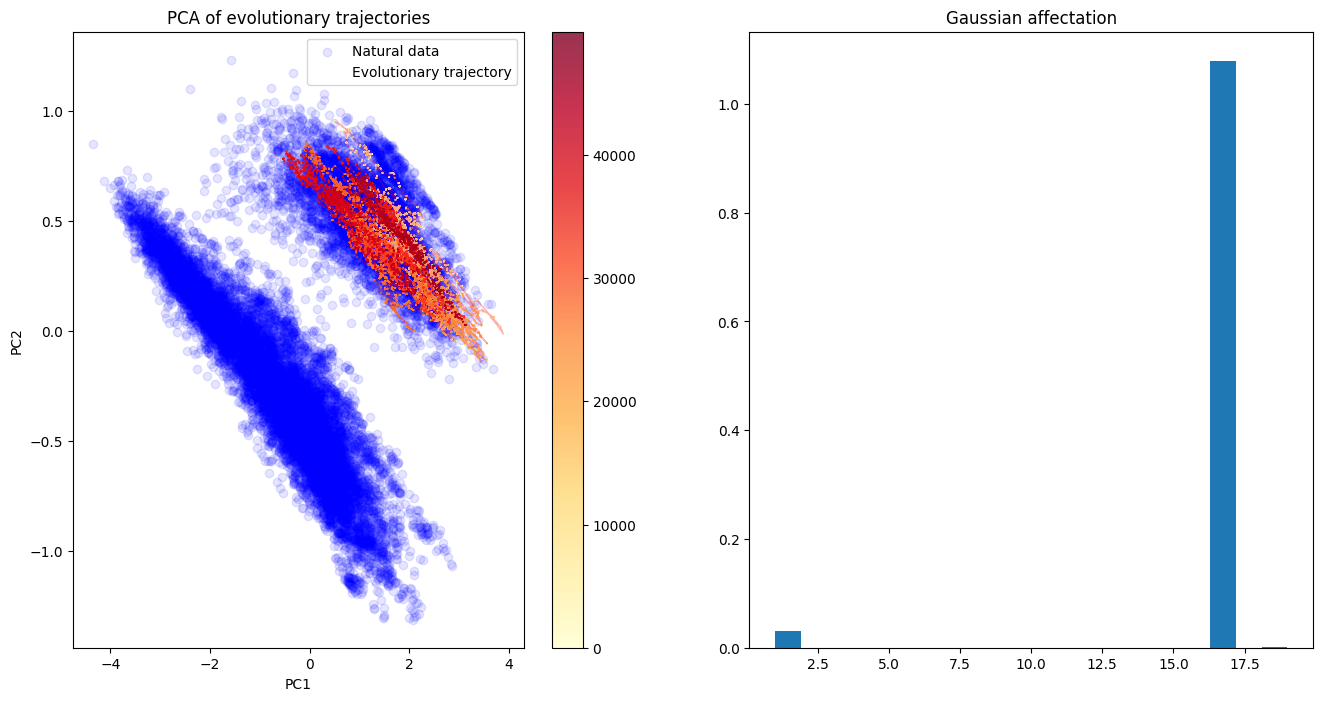

In [7]:
# PCA of evolutionary trajectories

X,Y,labels = my_scripts.generation_dataset(18000, SEED)
latent_X = AE_v1.encoder(torch.Tensor(X)).detach().numpy()

pca = PCA(2)
x = pca.fit_transform(latent_X)
x_traj = pca.transform(latent_traj)

gm_affect = gm.predict(latent_traj)

print("Explained Variance : ", pca.explained_variance_ratio_)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(x[:,0], x[:,1], c='b', alpha=0.1,label="Natural data")
plt.scatter(x_traj[:,0], x_traj[:,1], c=np.arange(x_traj.shape[0]), cmap="YlOrRd", s=0.1, alpha=0.8, label="Evolutionary trajectory") 
plt.plot(x_traj[:,0], x_traj[:,1], linewidth=1, c='r', alpha=0.3)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA of evolutionary trajectories')
plt.legend()
plt.colorbar()

plt.subplot(1,2,2)
plt.hist(gm_affect, density=True, bins=len(gm.weights_))
plt.title("Gaussian affectation")
plt.show()

Explained Variance :  [0.26884606 0.02910089]


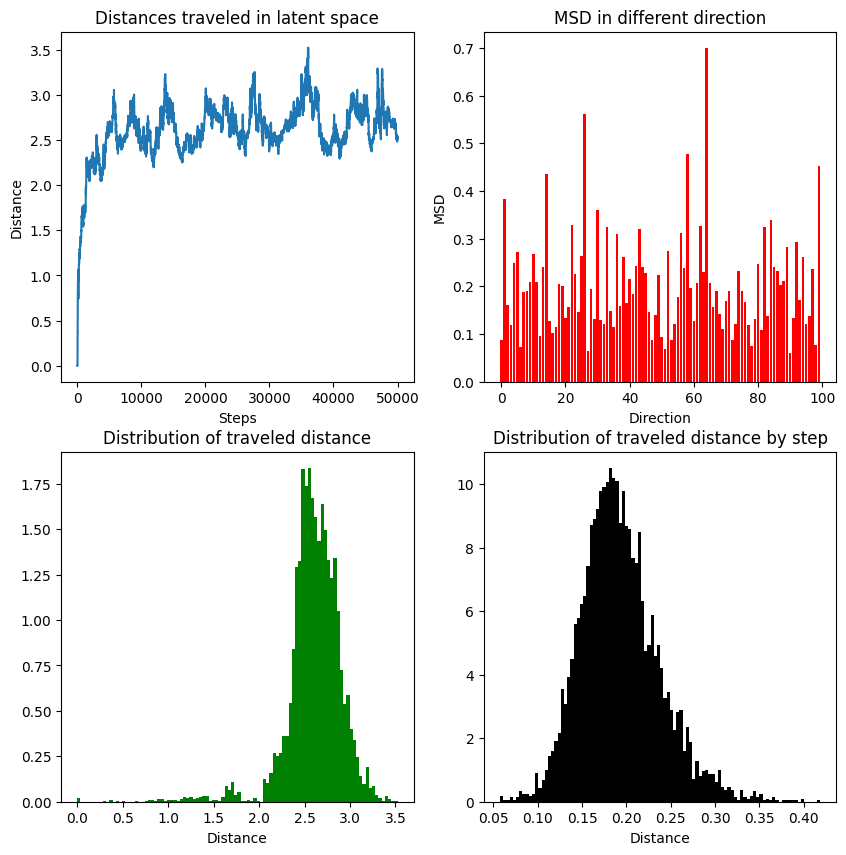

In [ ]:
msd = utils.MSD(latent_traj)
gm_affect = gm.predict(latent_traj)

d = utils.dist_profile(latent_traj)
d_traveled = utils.dist_traveled(latent_traj)
d_step = utils.step_distances(latent_traj)

end_traj = -1
print("Explained Variance : ", pca.explained_variance_ratio_)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(range(len(d_traveled)), d_traveled)
plt.title('Distances traveled in latent space')
plt.xlabel("Steps")
plt.ylabel("Distance")

plt.subplot(2,2,2)
plt.bar(range(len(d)), d, color='r')
plt.title("MSD in different direction")
plt.xlabel("Direction")
plt.ylabel("MSD")

plt.subplot(2,2,3)
plt.hist(d_traveled, bins=100, density=True, color='g')
plt.title("Distribution of traveled distance")
plt.xlabel("Distance")

plt.subplot(2,2,4)
plt.hist(d_step[d_step!=0], bins=100, density=True, color='k')
plt.title("Distribution of traveled distance by step")
plt.xlabel("Distance")


plt.show()

  0%|          | 0/50001 [00:00<?, ?it/s]

100%|██████████| 50001/50001 [03:09<00:00, 263.80it/s]


Gradient -> mean = 8.040e-03 | std = 3.585e+00 | median = 1.211e-47


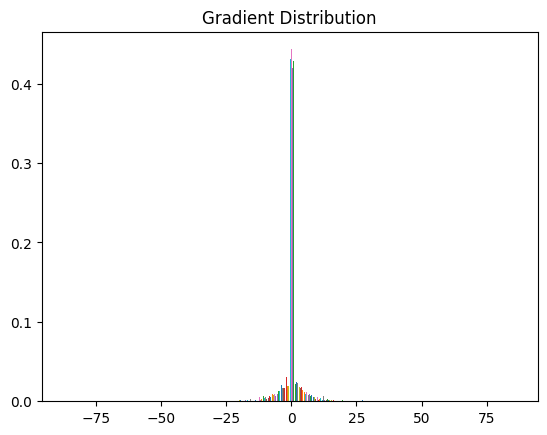

In [ ]:
#Compute gradient distribution

grad = np.zeros((latent_traj.shape[0], 100))
for i in tqdm.tqdm(range(latent_traj.shape[0])) : 

    grad[i] = gm2.grad(latent_traj[i])


print(f"Gradient -> mean = {grad.mean():.3e} | std = {grad.std():.3e} | median = {np.median(grad):.3e}")

plt.hist(grad, bins=100, density=True)
plt.title("Gradient Distribution")
plt.show()

100%|██████████| 20000/20000 [04:04<00:00, 81.68it/s] 


Pearson correlation : 0.0042


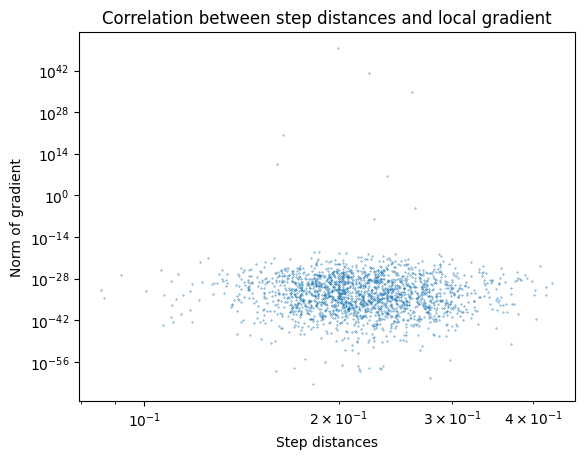

In [ ]:
# Correlation between step distances and local gradient

latent_distances = utils.step_distances(latent_traj)
grad_vec = []
for i in tqdm.tqdm(range(latent_traj.shape[0])) : 

    grad_vec.append(gm2.grad(latent_traj[i]))
grad = np.linalg.norm(grad_vec, axis=1) 

p = pearsonr(latent_distances, grad[:-1])

print(f"Pearson correlation : {p[0]:.4f}")

plt.scatter(latent_distances, grad[:-1], s=0.1)
plt.loglog()
plt.title("Correlation between step distances and local gradient")
plt.xlabel("Step distances")
plt.ylabel("Norm of gradient")

plt.show()

In [ ]:
# Compute distance traveled in latent space for long trajectories

D = np.zeros((1000, 50_001))

AE_v1.eval()
for i in tqdm.tqdm(range(120)):
    
    path = "/home/fefe/Documents/Stage/code/leonardodibari/leonardodibari-Gen.jl-bbc6b32/scra/amino_mixed_pf13354_steps500000001_seqs1000_T1.0p0.5/equil_det_bal_pf13354_silico_chain_num_" + str(i+1) + "_T_1.0.mixedDNA"
    seq = utils.read_fasta(path)
    X_traj = utils.one_hot_encode(seq, encoder)
    latent_traj = AE_v1.encoder(torch.Tensor(X_traj)).detach().numpy()
    d_traveled = utils.dist_traveled(latent_traj)
    D[i, :] = d_traveled

np.save("distance", D)

  0%|          | 0/120 [00:51<?, ?it/s]


ValueError: could not broadcast input array from shape (99983,) into shape (50001,)

Slope : 1.039 | Intercept : -3.435 | Step size : 0.032


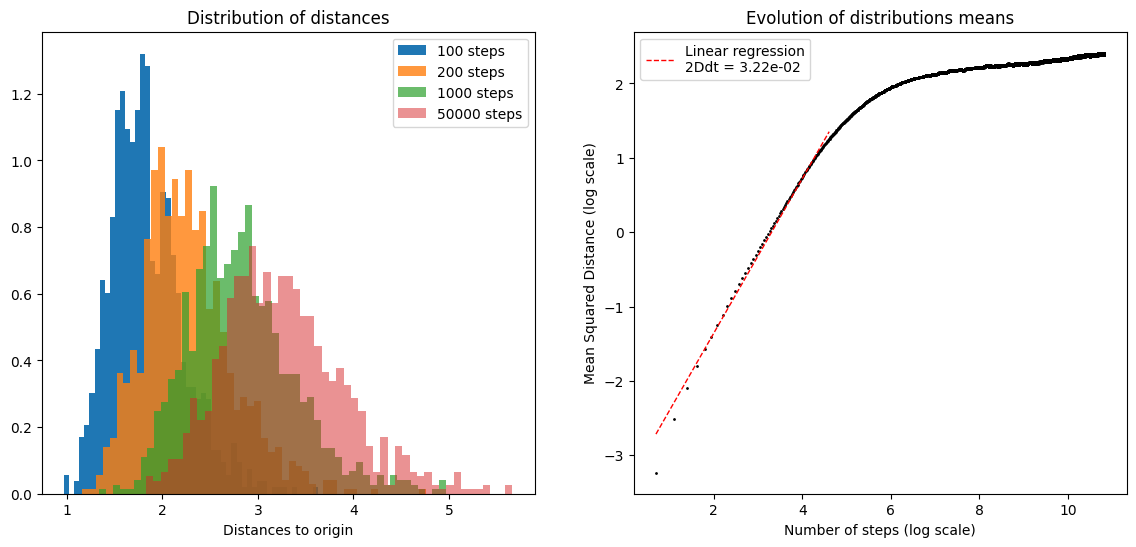

In [ ]:
D = np.load("distance.npy")

xend= 100

D_mean = D.mean(axis=0)
D2_mean = (D**2).mean(axis=0)
D_std = D.std(axis=0)

n = range(1, len(D2_mean)+1)
res = linregress(np.log(n[1:xend]), np.log(D2_mean[1:xend]))

print(f"Slope : {res[0]:.3f} | Intercept : {res[1]:.3f} | Step size : {np.exp(res[1]):.3f}")

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.hist(D[:,100], bins=50, density=True, label="100 steps")
plt.hist(D[:,200], bins=50, density=True, alpha=0.8, label="200 steps")
plt.hist(D[:,1000], bins=50, density=True, alpha=0.7, label="1000 steps")
plt.hist(D[:,50000], bins=50, density=True, alpha=0.5, label="50000 steps")
plt.legend()
plt.xlabel("Distances to origin")
plt.title("Distribution of distances")

plt.subplot(1,2,2)
plt.scatter(np.log(n[1:]), np.log(D2_mean[1:]), s=1, marker="o", c='k')
#plt.scatter(np.log(range(1,len(D_mean))), np.log(D_std[1:]), s=0.1, label="Standard Deviation")
plt.plot(np.log(n[1:xend]), res[0] * np.log(n[1:xend]) + res[1],
          c='r', linestyle='--', label=f"Linear regression\n2Ddt = {np.exp(res[1]):.2e}", linewidth=1)
#plt.loglog()
plt.xlabel("Number of steps (log scale)")
plt.ylabel("Mean Squared Distance (log scale)")
plt.legend()
#plt.xlim(0,2000)

plt.title("Evolution of distributions means")
plt.show()

$\langle r^2 \rangle \simeq 2Ddt n$



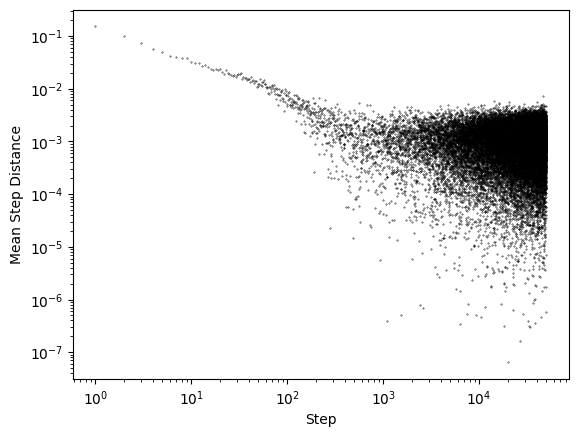

In [12]:
# Step distances

dD = D[:,1:] - D[:,:-1]
dD_mean = dD.mean(axis=0)

plt.scatter(range(1, len(dD_mean) + 1), dD_mean, s=0.1, c='k')
plt.loglog()
plt.xlabel("Step")
plt.ylabel("Mean Step Distance")
plt.show()